# Chapter 10: Time Series Analysis
## Recipes
* [Understanding the difference between Python and pandas date tools](#Understanding-the-difference-between-Python-and-pandas-date-tools)
* [Slicing time series intelligently](#Slicing-time-series-intelligently)
* [Using methods that only work with a DatetimeIndex](#Using-methods-that-only-work-with-a-DatetimeIndex)
* [Counting the number of weekly crimes](#Counting-the-number-of-weekly-crimes)
* [Aggregating weekly crime and traffic accidents separately](#Aggregating-weekly-crime-and-traffic-separately)
* [Measuring crime by weekday and year](#Measuring-crime-by-weekday-and-year)
* [Grouping with anonymous functions with a DatetimeIndex](#Grouping-with-anonymous-functions-with-a-DatetimeIndex)
* [Grouping by a Timestamp and another column](#Grouping-by-a-Timestamp-and-another-column)
* [Finding the last time crime was 20% lower with merge_asof](#Finding-the-last-time-crime-was-20%-lower-with-merge_asof)

# Introduction

The roots of pandas lay in analyzing financial time series data. The author, Wes McKinney,
was not satisfied with the available Python tools at that time, and decided to build pandas
to support his own needs at the hedge fund he was working at. Broadly speaking, time
series are simply points of data gathered over time. Most typically, the time is evenly
spaced between each data point. Pandas has excellent functionality with regards to
manipulating dates, aggregating over different time periods, sampling different periods of
time, and much more.

# Understanding the difference between Python and pandas date tools

Before we get to pandas, it can help to be aware of and understand core Python's date and
time functionality. The `datetime` module provides three distinct data types, `date`, `time`,
and `datetime`. Formally, a `date` is a moment in time consisting of just the year, month, and
day. For instance, June 7, 2013 would be a date. A `time` consists of hours, minutes, seconds,
and microseconds (one-millionth of a second) and is unattached to any date. An example of
time would be 12 hours and 30 minutes. A `datetime` consists of both the elements of a date
and time together.

On the other hand, pandas has a single object to encapsulate date and time called a
`Timestamp`. It has nanosecond (one-billionth of a second) precision and is derived from
NumPy's `datetime64` data type. Both Python and pandas each have a `timedelta` object
that is useful when doing date addition/subtraction.

## Getting ready

In this recipe, we will first explore Python's `datetime` module and then turn to the
corresponding and superior date tools in pandas.

## How to do it...

1. Let's begin by importing the `datetime` module into our namespace and creating
a `date`, `time`, and `datetime` object:

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
date = datetime.date(year=2013, month=6, day=7)
time = datetime.time(hour=12, minute=30, second=19, microsecond=463198)
dt = datetime.datetime(year=2013, month=6, day=7, 
                       hour=12, minute=30, second=19, microsecond=463198)
print("date is ", date)
print("time is", time)
print("datetime is", dt)

date is  2013-06-07
time is 12:30:19.463198
datetime is 2013-06-07 12:30:19.463198


2. Let's construct and print out a `timedelta` object, the other major data type from
the `datetime` module:

In [3]:
td = datetime.timedelta(weeks=2, days=5, hours=10, minutes=20, 
                        seconds=6.73, milliseconds=99, microseconds=8)
print(td)

19 days, 10:20:06.829008


3. Add/subtract this `timedelta` to the date and `datetime` objects from step 1:

In [4]:
print('new date is', date + td)
print('new datetime is', dt + td)

new date is 2013-06-26
new datetime is 2013-06-26 22:50:26.292206


4. Attempting to add a timedelta to a time object isn't possible:

```
>>> time + td
TypeError: unsupported operand type(s) for +: 'datetime.time' and 'datetime.timedelta'
```

5. Let's turn to pandas and its `Timestamp` object, which is a moment in time with
nanosecond precision. The `Timestamp` constructor is very flexible, and handles a
wide variety of inputs:

In [5]:
pd.Timestamp(year=2012, month=12, day=21, hour=5, minute=10, second=8, microsecond=99)

Timestamp('2012-12-21 05:10:08.000099')

In [6]:
pd.Timestamp('2016/1/10')

Timestamp('2016-01-10 00:00:00')

In [7]:
pd.Timestamp('2014-5/10')

Timestamp('2014-05-10 00:00:00')

In [8]:
pd.Timestamp('Jan 3, 2019 20:45.56')

Timestamp('2019-01-03 20:45:33')

In [9]:
pd.Timestamp('2016-01-05T05:34:43.123456789')

Timestamp('2016-01-05 05:34:43.123456789')

6. It's also possible to pass in a single integer or float to the `Timestamp` constructor
which returns a date equivalent to the number of nanoseconds after the Unix
epoch, which is January 1, 1970:

In [10]:
pd.Timestamp(500)

Timestamp('1970-01-01 00:00:00.000000500')

In [11]:
pd.Timestamp(5000, unit='D')

Timestamp('1983-09-10 00:00:00')

7. Pandas provides the `to_datetime` function that works fairly similarly to the
`Timestamp` constructor, but comes with a few different parameters for special
situations. See the following examples:

In [12]:
pd.to_datetime('2015-5-13')

Timestamp('2015-05-13 00:00:00')

In [13]:
pd.to_datetime('2015-13-5', dayfirst=True)

Timestamp('2015-05-13 00:00:00')

In [14]:
pd.Timestamp('Saturday September 30th, 2017')

Timestamp('2017-09-30 00:00:00')

In [15]:
pd.to_datetime('Start Date: Sep 30, 2017 Start Time: 1:30 pm', format='Start Date: %b %d, %Y Start Time: %I:%M %p')

Timestamp('2017-09-30 13:30:00')

In [16]:
pd.to_datetime(100, unit='D', origin='2013-1-1')

Timestamp('2013-04-11 00:00:00')

8. The `to_datetime` function comes equipped with even more functionality. It is
capable of converting entire lists or Series of strings or integers to Timestamps.
Since we are far more likely to interact with Series or DataFrames and not single
scalar values, you are far more likely to use `to_datetime` than `Timestamp`:

In [17]:
s = pd.Series([10, 100, 1000, 10000])
pd.to_datetime(s, unit='D')

0   1970-01-11
1   1970-04-11
2   1972-09-27
3   1997-05-19
dtype: datetime64[ns]

In [18]:
s = pd.Series(['12-5-2015', '14-1-2013', '20/12/2017', '40/23/2017'])
pd.to_datetime(s, dayfirst=True, errors='coerce')

0   2015-05-12
1   2013-01-14
2   2017-12-20
3          NaT
dtype: datetime64[ns]

In [19]:
pd.to_datetime(['Aug 3 1999 3:45:56', '10/31/2017'])

DatetimeIndex(['1999-08-03 03:45:56', '2017-10-31 00:00:00'], dtype='datetime64[ns]', freq=None)

9. Analogously to the `Timestamp` constructor and the `to_datetime` function,
pandas has `Timedelta` and `to_timedelta` to represent an amount of time. Both
the `Timedelta` constructor and the `to_timedelta` function can create a single
`Timedelta` object. Like `to_datetime`, `to_timedelta` has quite a bit more
functionality and can convert entire lists or Series into `Timedelta` objects.

In [20]:
pd.Timedelta('12 days 5 hours 3 minutes 123456789 nanoseconds')

Timedelta('12 days 05:03:00.123456789')

In [21]:
pd.Timedelta(days=5, minutes=7.34)

Timedelta('5 days 00:07:20.400000')

In [22]:
pd.Timedelta(100, unit='W')

Timedelta('700 days 00:00:00')

In [23]:
pd.to_timedelta('5 dayz', errors='ignore')

'5 dayz'

In [24]:
pd.to_timedelta('67:15:45.454')

Timedelta('2 days 19:15:45.454000')

In [25]:
s = pd.Series([10, 100])
pd.to_timedelta(s, unit='s')

0   0 days 00:00:10
1   0 days 00:01:40
dtype: timedelta64[ns]

In [26]:
time_strings = ['2 days 24 minutes 89.67 seconds', '00:45:23.6']
pd.to_timedelta(time_strings)

TimedeltaIndex(['2 days 00:25:29.670000', '0 days 00:45:23.600000'], dtype='timedelta64[ns]', freq=None)

10. Timedeltas may be added or subtracted from Timestamps and from each other.
They may even be divided from each other to return a float:

In [27]:
pd.Timedelta('12 days 5 hours 3 minutes') * 2

Timedelta('24 days 10:06:00')

In [28]:
pd.Timestamp('1/1/2017') + pd.Timedelta('12 days 5 hours 3 minutes') * 2

Timestamp('2017-01-25 10:06:00')

In [29]:
td1 = pd.to_timedelta([10, 100], unit='s')
td2 = pd.to_timedelta(['3 hours', '4 hours'])
td1 + td2

TimedeltaIndex(['0 days 03:00:10', '0 days 04:01:40'], dtype='timedelta64[ns]', freq=None)

In [30]:
pd.Timedelta('12 days') / pd.Timedelta('3 days')

4.0

11. Both Timestamps and Timedeltas have a large numbera of features available as
attributes and methods. Let's sample a few of them:

In [31]:
ts = pd.Timestamp('2016-10-1 4:23:23.9')

In [32]:
ts.ceil('h')

Timestamp('2016-10-01 05:00:00')

In [33]:
ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second

(2016, 10, 1, 4, 23, 23)

In [34]:
ts.dayofweek, ts.dayofyear, ts.daysinmonth

(5, 275, 31)

In [35]:
ts.to_pydatetime()

datetime.datetime(2016, 10, 1, 4, 23, 23, 900000)

In [36]:
td = pd.Timedelta(125.8723, unit='h')
td

Timedelta('5 days 05:52:20.280000')

In [37]:
td.round('min')

Timedelta('5 days 05:52:00')

In [38]:
td.components

Components(days=5, hours=5, minutes=52, seconds=20, milliseconds=280, microseconds=0, nanoseconds=0)

In [39]:
td.total_seconds()

453140.28

## How it works...

The `datetime` module is part of the Python standard library, and is very popular and
widely used. For this reason, it is a good idea to have some familiarity with it, as you will
likely cross paths with it. The `datetime` module is actually fairly simple with a total of only
six types of objects: `date`, `time`, `datetime`, `timedelta` along with two others on
timezones. The pandas `Timestamp` and `Timedelta` objects have all the functionality of
their `datetime` module counterparts and more. It will be possible to remain completely in
pandas when working with time series.

Step 1 shows how to create datetimes, dates, times, and timedeltas with the `datetime`
module. Only integers may be used as each component of the date or time, and are passed
as separate arguments. Compare this to step 5 where the pandas `Timestamp` constructor
can accept the same components as arguments, as well as a wide variety of date strings. In
addition to integer components and strings, step 6 shows how a single numeric scalar can
be used as a date. The units of this scalar are defaulted to *nanoseconds (ns)* but are changed
to *days (D)* in the second statement with the other options being *hours (h), minutes (m),
seconds (s), milliseconds (ms)*, and *microseconds (µs)*.

Step 2 details the construction of the `datetime` module's `timedelta` object with all of its
parameters. Again, compare this to the pandas `Timedelta` constructor shown in step 9,
which accepts these same parameters along with strings and scalar numerics.

In addition to the `Timestamp` and `Timedelta` constructors, which are only capable of
creating a single object, the `to_datetime` and `to_timedelta` functions can convert entire
sequences of integers or strings to the desired type. These functions also provide several
more parameters not available with the constructors. One of these parameters is `errors`,
which is defaulted to the string value *raise* but can also be set to *ignore* or *coerce*. Whenever a
string date is unable to be converted, the `errors` parameter determines what action to take.
When set to *raise*, an exception is raised and program execution stops. When set to *ignore*,
the original sequence gets returned as it was prior to entering the function. When set to
*coerce*, the `NaT` (not a time) object is used to represent the new value. The second statement
of step 8 converts all values to a `Timestamp` correctly, except for the last one, which is
forced to become `NaT`.

Another one of these parameters available only `to` to_datetime is `format`, which is
particularly useful whenever a string contains a particular date pattern that is not
automatically recognized by pandas. In the third statement of step 7, we have a datetime
enmeshed inside some other characters. We substitute the date and time pieces of the string
with their respective **formatting directives**.

A date formatting directive appears as a single percentage sign, %,
followed by a single character. Each directive specifies some part of a date
or time. See the official Python documentation for a table of all the
directives (`http:/​/​bit.​ly/​2kePoRe`).

## There's more...

The date formatting directive can actually make quite a large difference when converting a
large sequence of strings to Timestamps. Whenever pandas uses `to_datetime` to convert a
sequence of strings to Timestamps, it searches a large number of different string
combinations that represent dates. This is true even if all the strings have the same format.
With the `format` parameter, we can specify the exact date format, so that pandas doesn't
have to search for the correct one each time. Let's create a list of dates as strings and time
their conversion to Timestamps both with and without a formatting directive:

In [40]:
date_string_list = ['Sep 30 1984'] * 10000

In [41]:
%timeit pd.to_datetime(date_string_list, format='%b %d %Y')

2.82 ms ± 96 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit pd.to_datetime(date_string_list)

2.85 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Slicing time series intelligently

DataFrame selection and slicing was thoroughly covered in `Chapter 4`, *Selecting Subsets of
Data*. When the DataFrame posses a `DatetimeIndex`, even more opportunities arise for
selection and slicing.

## Getting ready

In this recipe, we will use partial date matching to select and slice a DataFrame with a
`DatetimeIndex`.

## How to do it...

1. Read in the Denver `crimes` dataset from the `hdf5` file `crimes.h5`, and output
the column data types and the first few rows. The `hdf5` file format allows
efficient storage of large scientific data and is completely different from a CSV
text file.

In [43]:
crime = pd.read_hdf('data/crime.h5', 'crime')
crime.dtypes

OFFENSE_TYPE_ID              category
OFFENSE_CATEGORY_ID          category
REPORTED_DATE          datetime64[ns]
GEO_LON                       float64
GEO_LAT                       float64
NEIGHBORHOOD_ID              category
IS_CRIME                        int64
IS_TRAFFIC                      int64
dtype: object

2. Notice that there are three categorical columns and a `Timestamp` (denoted by
NumPy's `datetime64` object). These data types were stored whenever the data
file was created, unlike a CSV file, which only stores raw text. Set the
`REPORTED_DATE` column as the index in order to make intelligent Timestamp
slicing possible:

In [44]:
crime = crime.set_index('REPORTED_DATE')
crime.head()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                         
2014-06-29 02:01:00   traffic-accident-dui-duid    traffic-accident   
2014-06-29 01:54:00  vehicular-eluding-no-chase    all-other-crimes   
2014-06-29 02:00:00        disturbing-the-peace     public-disorder   
2014-06-29 02:18:00                      curfew     public-disorder   
2014-06-29 04:17:00          aggravated-assault  aggravated-assault   

                        GEO_LON    GEO_LAT            NEIGHBORHOOD_ID  \
REPORTED_DATE                                                           
2014-06-29 02:01:00 -105.000149  39.745753                        cbd   
2014-06-29 01:54:00 -104.884660  39.738702                east-colfax   
2014-06-29 02:00:00 -105.020719  39.706674                athmar-park   
2014-06-29 02:18:00 -105.001552  39.769505                  sunnyside   
2014-06-29 04:17:00 -105.018557  39.679229  college-view-south-platte   

                     IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                              
2014-06-29 02:01:00         0           1  
2014-06-29 01:54:00         1           0  
2014-06-29 02:00:00         1           0  
2014-06-29 02:18:00         1           0  
2014-06-29 04:17:00         1           0

In [45]:
pd.options.display.max_rows = 4

3. As usual, it is possible to select all the rows equal to a single index by passing that
value to the `.loc` indexing operator:

In [46]:
crime.loc['2016-05-12 16:45:00']

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID     GEO_LON  \
REPORTED_DATE                                                               
2016-05-12 16:45:00      traffic-accident    traffic-accident -104.847024   
2016-05-12 16:45:00      traffic-accident    traffic-accident -105.049180   
2016-05-12 16:45:00  fraud-identity-theft  white-collar-crime -104.931971   

                       GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                                                         
2016-05-12 16:45:00  39.779596       montbello         0           1  
2016-05-12 16:45:00  39.769296   west-highland         0           1  
2016-05-12 16:45:00  39.717359         hilltop         1           0

4. With a `Timestamp` in the index, it is possible to select all rows that partially
match an index value. For instance, if we wanted all the crimes from May 5, 2016,
we would simply select it as follows:

In [47]:
crime.loc['2016-05-12']

OFFENSE_TYPE_ID           OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                                
2016-05-12 23:51:00  criminal-mischief-other               public-disorder   
2016-05-12 18:40:00        liquor-possession                  drug-alcohol   
...                                      ...                           ...   
2016-05-12 15:59:00   menacing-felony-w-weap            aggravated-assault   
2016-05-12 16:39:00               assault-dv  other-crimes-against-persons   

                        GEO_LON    GEO_LAT     NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                              
2016-05-12 23:51:00 -105.017241  39.705845         athmar-park         1   
2016-05-12 18:40:00 -104.995692  39.747875                 cbd         1   
...                         ...        ...                 ...       ...   
2016-05-12 15:59:00 -104.935172  39.723703             hilltop         1   
2016-05-12 16:39:00 -104.974700  39.740555  north-capitol-hill         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2016-05-12 23:51:00           0  
2016-05-12 18:40:00           0  
...                         ...  
2016-05-12 15:59:00           0  
2016-05-12 16:39:00           0  

[243 rows x 7 columns]

5. Not only can you select a single date inexactly, but you can do so for an entire
month, year, or even hour of the day:

In [48]:
crime.loc['2016-05'].shape

(8012, 7)

In [49]:
crime.loc['2016'].shape

(91076, 7)

In [50]:
crime.loc['2016-05-12 03'].shape

(4, 7)

6. The selection strings may also contain the name of the month:

In [51]:
crime.loc['Dec 2015'].sort_index()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2015-12-01 00:48:00            drug-cocaine-possess        drug-alcohol   
2015-12-01 00:48:00          theft-of-motor-vehicle          auto-theft   
...                                             ...                 ...   
2015-12-31 23:45:00  violation-of-restraining-order    all-other-crimes   
2015-12-31 23:50:00   weapon-poss-illegal-dangerous    all-other-crimes   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2015-12-01 00:48:00 -104.891681  39.740155     east-colfax         1   
2015-12-01 00:48:00 -104.891681  39.740155     east-colfax         1   
...                         ...        ...             ...       ...   
2015-12-31 23:45:00 -105.034887  39.741827     west-colfax         1   
2015-12-31 23:50:00 -105.032769  39.709188        westwood         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2015-12-01 00:48:00           0  
2015-12-01 00:48:00           0  
...                         ...  
2015-12-31 23:45:00           0  
2015-12-31 23:50:00           0  

[6907 rows x 7 columns]

7. Many other string patterns with month name included also work:

In [52]:
crime.loc['2016 Sep, 15'].shape

(252, 7)

In [53]:
crime.loc['21st October 2014 05'].shape

(4, 7)

8. In addition to selection, you may use the slice notation to select precise ranges of
data:

In [54]:
crime.loc['2015-3-4':'2016-1-1'].sort_index()

OFFENSE_TYPE_ID           OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                                
2015-03-04 00:11:00               assault-dv  other-crimes-against-persons   
2015-03-04 00:19:00               assault-dv  other-crimes-against-persons   
...                                      ...                           ...   
2016-01-01 23:45:00     drug-cocaine-possess                  drug-alcohol   
2016-01-01 23:48:00  drug-poss-paraphernalia                  drug-alcohol   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2015-03-04 00:11:00 -105.021966  39.770883       sunnyside         1   
2015-03-04 00:19:00 -104.978988  39.748799     five-points         1   
...                         ...        ...             ...       ...   
2016-01-01 23:45:00 -104.987310  39.753598     five-points         1   
2016-01-01 23:48:00 -104.986020  39.752541     five-points         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2015-03-04 00:11:00           0  
2015-03-04 00:19:00           0  
...                         ...  
2016-01-01 23:45:00           0  
2016-01-01 23:48:00           0  

[75403 rows x 7 columns]

9. Notice that all crimes committed on the end date regardless of the time are
included in the returned result. This is true for any result using the label-based
`.loc` indexer. You can provide as much precision (or lack thereof) to any start or
end portion of the slice:

In [55]:
crime.loc['2015-3-4 22':'2016-1-1 23:45:00'].sort_index()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                           
2015-03-04 22:25:00  traffic-accident-hit-and-run    traffic-accident   
2015-03-04 22:30:00              traffic-accident    traffic-accident   
...                                           ...                 ...   
2016-01-01 23:40:00              robbery-business             robbery   
2016-01-01 23:45:00          drug-cocaine-possess        drug-alcohol   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2015-03-04 22:25:00 -104.973896  39.769064     five-points         0   
2015-03-04 22:30:00 -104.906412  39.632816   hampden-south         0   
...                         ...        ...             ...       ...   
2016-01-01 23:40:00 -105.039236  39.726157      villa-park         1   
2016-01-01 23:45:00 -104.987310  39.753598     five-points         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2015-03-04 22:25:00           1  
2015-03-04 22:30:00           1  
...                         ...  
2016-01-01 23:40:00           0  
2016-01-01 23:45:00           0  

[75175 rows x 7 columns]

## How it works...

One of the many nice features of `hdf5` files is their ability to preserve the data types of each
column, which substantially reduces the memory needed. In this case, three of these
columns are stored as a pandas category instead of as an object. Storing them as object will
lead to a four times increase in memory usage:

In [56]:
mem_cat = crime.memory_usage().sum()
mem_obj = crime.astype({'OFFENSE_TYPE_ID':'object', 
                        'OFFENSE_CATEGORY_ID':'object', 
                        'NEIGHBORHOOD_ID':'object'}).memory_usage(deep=True)\
                                                    .sum()
mb = 2 ** 20
round(mem_cat / mb, 1), round(mem_obj / mb, 1)

(27.4, 120.8)

In order to intelligently select and slice rows by date using the indexing operator, the index
must contain date values. In step 2, we move the `REPORTED_DATE` column into the index
and formally create a `DatetimeIndex` as the new index:

In [57]:
crime.index[:2]

DatetimeIndex(['2014-06-29 02:01:00', '2014-06-29 01:54:00'], dtype='datetime64[ns]', name='REPORTED_DATE', freq=None)

With a `DatetimeIndex`, a huge variety of strings may be used to select rows with the `.loc`
indexer. In fact, all strings that can be sent to the pandas `Timestamp` constructor will work
here. Surprisingly, it is actually not necessary to use the `.loc` indexer for any of the
selections or slices in this recipe. The indexing operator by itself will work in exactly the
same manner. For instance, the second statement of step 6 may be written as `crime['21st
October 2014 05']`. The indexing operator is normally reserved for columns but flexibly
allows for Timestamps to be used whenever there exists a `DatetimeIndex`.

Personally, I prefer using the `.loc` indexer when selecting rows and would always use it
over the indexing operator by itself. The `.loc` indexer is explicit and the first value passed
to it is always used to select rows.

Steps 8 and 9 show how slicing works in the same manner as selection from the previous
steps. Any date that partially matches either the start or end value of the slice is included in
the result.

## There's more...

Our original crimes DataFrame was not sorted and slicing still worked as expected. Sorting
the index will lead to large gains in performance. Let's see the difference with slicing done
from step 8:

In [58]:
%timeit crime.loc['2015-3-4':'2016-1-1']

9.39 ms ± 503 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
crime_sort = crime.sort_index()

In [60]:
%timeit crime_sort.loc['2015-3-4':'2016-1-1']

1.14 ms ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The sorted DataFrame provides an impressive 50 times performance improvement over the
original.

In [61]:
pd.options.display.max_rows = 60

# Using methods that only work with a DatetimeIndex

There are a number of DataFrame/Series methods that only work with a DatetimeIndex. If
the index is of any other type, these methods will fail.

## Getting ready

In this recipe, we will first use methods to select rows of data by their time component. We
will then learn about the powerful DateOffset objects and their aliases.

## How to do it...

1. Read in the crime hdf5 dataset, set the index as `REPORTED_DATE`, and ensure that
we have a DatetimeIndex:

In [62]:
crime = pd.read_hdf('data/crime.h5', 'crime').set_index('REPORTED_DATE')
print(type(crime.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


2. Use the `between_time` method to select all crimes that occurred between 2 a.m.
and 5 a.m., regardless of the date:

In [63]:
crime.between_time('2:00', '5:00', include_end=False).head()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2014-06-29 02:01:00       traffic-accident-dui-duid    traffic-accident   
2014-06-29 02:00:00            disturbing-the-peace     public-disorder   
2014-06-29 02:18:00                          curfew     public-disorder   
2014-06-29 04:17:00              aggravated-assault  aggravated-assault   
2014-06-29 04:22:00  violation-of-restraining-order    all-other-crimes   

                        GEO_LON    GEO_LAT            NEIGHBORHOOD_ID  \
REPORTED_DATE                                                           
2014-06-29 02:01:00 -105.000149  39.745753                        cbd   
2014-06-29 02:00:00 -105.020719  39.706674                athmar-park   
2014-06-29 02:18:00 -105.001552  39.769505                  sunnyside   
2014-06-29 04:17:00 -105.018557  39.679229  college-view-south-platte   
2014-06-29 04:22:00 -104.972447  39.739449              cheesman-park   

                     IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                              
2014-06-29 02:01:00         0           1  
2014-06-29 02:00:00         1           0  
2014-06-29 02:18:00         1           0  
2014-06-29 04:17:00         1           0  
2014-06-29 04:22:00         1           0

3. Select all dates at a specific time with `at_time`:

In [64]:
crime.at_time('5:47').head()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                        
2013-11-26 05:47:00    criminal-mischief-other     public-disorder   
2017-04-09 05:47:00  criminal-mischief-mtr-veh     public-disorder   
2017-02-19 05:47:00    criminal-mischief-other     public-disorder   
2017-02-16 05:47:00         aggravated-assault  aggravated-assault   
2017-02-12 05:47:00        police-interference    all-other-crimes   

                        GEO_LON    GEO_LAT     NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                              
2013-11-26 05:47:00 -104.991476  39.751536                 cbd         1   
2017-04-09 05:47:00 -104.959394  39.678425          university         1   
2017-02-19 05:47:00 -104.986767  39.741336  north-capitol-hill         1   
2017-02-16 05:47:00 -104.934029  39.732320                hale         1   
2017-02-12 05:47:00 -104.976306  39.722644               speer         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2013-11-26 05:47:00           0  
2017-04-09 05:47:00           0  
2017-02-19 05:47:00           0  
2017-02-16 05:47:00           0  
2017-02-12 05:47:00           0

4. The `first` methods provide an elegant way of selecting the first n segments of
time, where `n` is an integer. These segments of time are formally represented by
DateOffset objects that can be in the `pd.offsets` module. The DataFrame must
be sorted on its index to guarantee that this method will work. Let's select the
first six months of crime data:

In [65]:
crime_sort = crime.sort_index()

In [66]:
pd.options.display.max_rows = 6

In [67]:
crime_sort.first(pd.offsets.MonthBegin(6))

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2012-01-02 00:06:00              aggravated-assault  aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order    all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid    traffic-accident   
...                                             ...                 ...   
2012-06-30 23:50:00       criminal-mischief-mtr-veh     public-disorder   
2012-06-30 23:54:00    traffic-accident-hit-and-run    traffic-accident   
2012-07-01 00:01:00                  robbery-street             robbery   

                        GEO_LON    GEO_LAT      NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                               
2012-01-02 00:06:00 -104.816860  39.796717            montbello         1   
2012-01-02 00:06:00 -104.816860  39.796717            montbello         1   
2012-01-02 00:16:00 -104.971851  39.736874        cheesman-park         0   
...                         ...        ...                  ...       ...   
2012-06-30 23:50:00 -104.838271  39.788683            montbello         1   
2012-06-30 23:54:00 -105.014162  39.740439         lincoln-park         0   
2012-07-01 00:01:00 -104.924292  39.767585  northeast-park-hill         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2012-01-02 00:06:00           0  
2012-01-02 00:06:00           0  
2012-01-02 00:16:00           1  
...                         ...  
2012-06-30 23:50:00           0  
2012-06-30 23:54:00           1  
2012-07-01 00:01:00           0  

[27489 rows x 7 columns]

5. This captured the data from January through June but also, surprisingly, selected
a single row in July. The reason for this is that pandas actually uses the time
component of the first element in the index, which, in this example, is 6 minutes.
Let's use `MonthEnd`, a slightly different offset:

In [68]:
crime_sort.first(pd.offsets.MonthEnd(6))

OFFENSE_TYPE_ID  \
REPORTED_DATE                                         
2012-01-02 00:06:00              aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order   
2012-01-02 00:16:00       traffic-accident-dui-duid   
...                                             ...   
2012-06-29 23:41:00                  robbery-street   
2012-06-29 23:57:00                  assault-simple   
2012-06-30 00:04:00                traffic-accident   

                              OFFENSE_CATEGORY_ID     GEO_LON    GEO_LAT  \
REPORTED_DATE                                                              
2012-01-02 00:06:00            aggravated-assault -104.816860  39.796717   
2012-01-02 00:06:00              all-other-crimes -104.816860  39.796717   
2012-01-02 00:16:00              traffic-accident -104.971851  39.736874   
...                                           ...         ...        ...   
2012-06-29 23:41:00                       robbery -104.991912  39.756163   
2012-06-29 23:57:00  other-crimes-against-persons -104.987360  39.715162   
2012-06-30 00:04:00              traffic-accident -104.894697  39.628902   

                    NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                                              
2012-01-02 00:06:00       montbello         1           0  
2012-01-02 00:06:00       montbello         1           0  
2012-01-02 00:16:00   cheesman-park         0           1  
...                             ...       ...         ...  
2012-06-29 23:41:00     five-points         1           0  
2012-06-29 23:57:00           speer         1           0  
2012-06-30 00:04:00   hampden-south         0           1  

[27332 rows x 7 columns]

6. This captured nearly the same amount of data but if you look closely, only a
single row from June 30th was captured. Again, this is because the time
component of the first index was preserved. The exact search went to `2012-06-30
00:06:00`. So, how do we get exactly six months of data? There are a couple of
ways. All DateOffsets have a `normalize` parameter that, when set to `True`, sets
all the time components to zero. The following should get us very close to what
we want:

In [69]:
crime_sort.first(pd.offsets.MonthBegin(6, normalize=True))

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2012-01-02 00:06:00              aggravated-assault  aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order    all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid    traffic-accident   
...                                             ...                 ...   
2012-06-30 23:44:00                traffic-accident    traffic-accident   
2012-06-30 23:50:00       criminal-mischief-mtr-veh     public-disorder   
2012-06-30 23:54:00    traffic-accident-hit-and-run    traffic-accident   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:16:00 -104.971851  39.736874   cheesman-park         0   
...                         ...        ...             ...       ...   
2012-06-30 23:44:00 -104.987578  39.711158           baker         0   
2012-06-30 23:50:00 -104.838271  39.788683       montbello         1   
2012-06-30 23:54:00 -105.014162  39.740439    lincoln-park         0   

                     IS_TRAFFIC  
REPORTED_DATE                    
2012-01-02 00:06:00           0  
2012-01-02 00:06:00           0  
2012-01-02 00:16:00           1  
...                         ...  
2012-06-30 23:44:00           1  
2012-06-30 23:50:00           0  
2012-06-30 23:54:00           1  

[27488 rows x 7 columns]

7. This method has successfully captured all the data for the first six months of the
year. With normalize set to `True`, the search went to `2012-07-01 00:00:00`, which
would actually include any crimes reported exactly on this date and time.
Actually, there is no possible way to use the first method to ensure that only data
from January to June is captured. The following very simple slice would yield the
exact result:

In [70]:
crime_sort.loc[:'2012-06']

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2012-01-02 00:06:00              aggravated-assault  aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order    all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid    traffic-accident   
...                                             ...                 ...   
2012-06-30 23:44:00                traffic-accident    traffic-accident   
2012-06-30 23:50:00       criminal-mischief-mtr-veh     public-disorder   
2012-06-30 23:54:00    traffic-accident-hit-and-run    traffic-accident   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:16:00 -104.971851  39.736874   cheesman-park         0   
...                         ...        ...             ...       ...   
2012-06-30 23:44:00 -104.987578  39.711158           baker         0   
2012-06-30 23:50:00 -104.838271  39.788683       montbello         1   
2012-06-30 23:54:00 -105.014162  39.740439    lincoln-park         0   

                     IS_TRAFFIC  
REPORTED_DATE                    
2012-01-02 00:06:00           0  
2012-01-02 00:06:00           0  
2012-01-02 00:16:00           1  
...                         ...  
2012-06-30 23:44:00           1  
2012-06-30 23:50:00           0  
2012-06-30 23:54:00           1  

[27488 rows x 7 columns]

8. There are a dozen DateOffset objects for very precisely moving forward or
backward to the next nearest offset. Instead of hunting down the DateOffset
objects in `pd.offsets`, you can use a string called an **offset alias** instead. For
instance, the string for MonthEnd is M and for MonthBegin is `MS`. To denote the
number of these offset aliases, simply place an integer in front of it. Use this table
to find all the aliases (`http:/​/​bit.​ly/​2xO5Yg0`). Let's see some examples of offset
aliases with the description of what is being selected in the comments:

In [71]:
crime_sort.first('5D')

OFFENSE_TYPE_ID  \
REPORTED_DATE                                         
2012-01-02 00:06:00              aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order   
2012-01-02 00:16:00       traffic-accident-dui-duid   
...                                             ...   
2012-01-06 23:30:00                      assault-dv   
2012-01-06 23:44:00          theft-of-motor-vehicle   
2012-01-06 23:55:00               threats-to-injure   

                              OFFENSE_CATEGORY_ID     GEO_LON    GEO_LAT  \
REPORTED_DATE                                                              
2012-01-02 00:06:00            aggravated-assault -104.816860  39.796717   
2012-01-02 00:06:00              all-other-crimes -104.816860  39.796717   
2012-01-02 00:16:00              traffic-accident -104.971851  39.736874   
...                                           ...         ...        ...   
2012-01-06 23:30:00  other-crimes-against-persons -104.958983  39.674135   
2012-01-06 23:44:00                    auto-theft -104.845356  39.794035   
2012-01-06 23:55:00               public-disorder -105.004788  39.708714   

                     NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                                               
2012-01-02 00:06:00        montbello         1           0  
2012-01-02 00:06:00        montbello         1           0  
2012-01-02 00:16:00    cheesman-park         0           1  
...                              ...       ...         ...  
2012-01-06 23:30:00  university-park         1           0  
2012-01-06 23:44:00        montbello         1           0  
2012-01-06 23:55:00      athmar-park         1           0  

[605 rows x 7 columns]

In [72]:
crime_sort.first('5B')

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2012-01-02 00:06:00              aggravated-assault  aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order    all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid    traffic-accident   
...                                             ...                 ...   
2012-01-08 23:52:00                     theft-other             larceny   
2012-01-09 00:04:00    traffic-accident-hit-and-run    traffic-accident   
2012-01-09 00:05:00    fraud-criminal-impersonation  white-collar-crime   

                        GEO_LON    GEO_LAT NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                          
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:06:00 -104.816860  39.796717       montbello         1   
2012-01-02 00:16:00 -104.971851  39.736874   cheesman-park         0   
...                         ...        ...             ...       ...   
2012-01-08 23:52:00 -104.968227  39.739752   cheesman-park         1   
2012-01-09 00:04:00 -104.973343  39.760757     five-points         0   
2012-01-09 00:05:00 -105.024676  39.712702        valverde         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2012-01-02 00:06:00           0  
2012-01-02 00:06:00           0  
2012-01-02 00:16:00           1  
...                         ...  
2012-01-08 23:52:00           0  
2012-01-09 00:04:00           1  
2012-01-09 00:05:00           0  

[879 rows x 7 columns]

In [73]:
crime_sort.first('7W')

OFFENSE_TYPE_ID       OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                                   
2012-01-02 00:06:00              aggravated-assault        aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order          all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid          traffic-accident   
...                                             ...                       ...   
2012-02-18 22:20:00       traffic-accident-dui-duid          traffic-accident   
2012-02-18 22:44:00       criminal-mischief-mtr-veh           public-disorder   
2012-02-18 23:27:00        theft-items-from-vehicle  theft-from-motor-vehicle   

                        GEO_LON    GEO_LAT  NEIGHBORHOOD_ID  IS_CRIME  \
REPORTED_DATE                                                           
2012-01-02 00:06:00 -104.816860  39.796717        montbello         1   
2012-01-02 00:06:00 -104.816860  39.796717        montbello         1   
2012-01-02 00:16:00 -104.971851  39.736874    cheesman-park         0   
...                         ...        ...              ...       ...   
2012-02-18 22:20:00 -104.919946  39.761917  north-park-hill         0   
2012-02-18 22:44:00 -105.044984  39.736776      west-colfax         1   
2012-02-18 23:27:00 -105.009018  39.708701      athmar-park         1   

                     IS_TRAFFIC  
REPORTED_DATE                    
2012-01-02 00:06:00           0  
2012-01-02 00:06:00           0  
2012-01-02 00:16:00           1  
...                         ...  
2012-02-18 22:20:00           1  
2012-02-18 22:44:00           0  
2012-02-18 23:27:00           0  

[6708 rows x 7 columns]

In [74]:
crime_sort.first('3QS')

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
REPORTED_DATE                                                             
2012-01-02 00:06:00              aggravated-assault  aggravated-assault   
2012-01-02 00:06:00  violation-of-restraining-order    all-other-crimes   
2012-01-02 00:16:00       traffic-accident-dui-duid    traffic-accident   
...                                             ...                 ...   
2012-09-30 23:29:00          theft-of-motor-vehicle          auto-theft   
2012-09-30 23:41:00    traffic-accident-hit-and-run    traffic-accident   
2012-09-30 23:43:00                robbery-business             robbery   

                        GEO_LON    GEO_LAT             NEIGHBORHOOD_ID  \
REPORTED_DATE                                                            
2012-01-02 00:06:00 -104.816860  39.796717                   montbello   
2012-01-02 00:06:00 -104.816860  39.796717                   montbello   
2012-01-02 00:16:00 -104.971851  39.736874               cheesman-park   
...                         ...        ...                         ...   
2012-09-30 23:29:00 -104.988838  39.686925                    overland   
2012-09-30 23:41:00 -105.087598  39.638462                     marston   
2012-09-30 23:43:00 -104.772712  39.781966  gateway-green-valley-ranch   

                     IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                              
2012-01-02 00:06:00         1           0  
2012-01-02 00:06:00         1           0  
2012-01-02 00:16:00         0           1  
...                       ...         ...  
2012-09-30 23:29:00         1           0  
2012-09-30 23:41:00         0           1  
2012-09-30 23:43:00         1           0  

[43045 rows x 7 columns]

## How it works...

Once we ensure that our index is a DatetimeIndex, we can take advantage of all the
methods in this recipe. It is impossible to do selection or slicing based on just the time
component of a `Timestamp` with the `.loc` indexer. To select all dates by a range of time,
you must use the `between_time` method, or to select an exact time, use `at_time`. Make
sure that the passed string for start and end times consists of at least the hour and minute. It
is also possible to use time objects from the `datetime` module. For instance, the following
command would yield the same result as in step 2:

In [75]:
import datetime
crime.between_time(datetime.time(2,0), datetime.time(5,0), include_end=False)

OFFENSE_TYPE_ID  \
REPORTED_DATE                                       
2014-06-29 02:01:00     traffic-accident-dui-duid   
2014-06-29 02:00:00          disturbing-the-peace   
2014-06-29 02:18:00                        curfew   
...                                           ...   
2017-09-13 02:21:00                assault-simple   
2017-09-13 03:21:00     traffic-accident-dui-duid   
2017-09-13 02:15:00  traffic-accident-hit-and-run   

                              OFFENSE_CATEGORY_ID     GEO_LON    GEO_LAT  \
REPORTED_DATE                                                              
2014-06-29 02:01:00              traffic-accident -105.000149  39.745753   
2014-06-29 02:00:00               public-disorder -105.020719  39.706674   
2014-06-29 02:18:00               public-disorder -105.001552  39.769505   
...                                           ...         ...        ...   
2017-09-13 02:21:00  other-crimes-against-persons -104.925733  39.654184   
2017-09-13 03:21:00              traffic-accident -105.010711  39.757385   
2017-09-13 02:15:00              traffic-accident -105.043950  39.787436   

                      NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
REPORTED_DATE                                                
2014-06-29 02:01:00               cbd         0           1  
2014-06-29 02:00:00       athmar-park         1           0  
2014-06-29 02:18:00         sunnyside         1           0  
...                               ...       ...         ...  
2017-09-13 02:21:00  university-hills         1           0  
2017-09-13 03:21:00          highland         0           1  
2017-09-13 02:15:00             regis         0           1  

[29078 rows x 7 columns]

In step 4, we begin using the simple `first` method, but with a complicated parameter
`offset`. It must be a DateOffset object or an offset alias as a string. To help understand
DateOffset objects, it's best to see what they do to a single `Timestamp`. For example, let's
take the first element of the index and add six months to it in two different ways:

In [76]:
first_date = crime_sort.index[0]
first_date

Timestamp('2012-01-02 00:06:00')

In [77]:
first_date + pd.offsets.MonthBegin(6)

Timestamp('2012-07-01 00:06:00')

In [78]:
first_date + pd.offsets.MonthEnd(6)

Timestamp('2012-06-30 00:06:00')

Both the `MonthBegin` and `MonthEnd` offsets don't add or subtract an exact amount of time
but effectively round up to the next beginning or end of the month regardless of what day it
is. Internally, the `first` method uses the very first index element of the DataFrame and
adds the DateOffset passed to it. It then slices up until this new date. For instance, step 4 is
equivalent to the following:

In [79]:
step4 = crime_sort.first(pd.offsets.MonthEnd(6))
end_dt = crime_sort.index[0] + pd.offsets.MonthEnd(6)
step4_internal = crime_sort[:end_dt]
step4.equals(step4_internal)

True

Steps 5 through 7 follow from this preceding equivalence directly. In step 8, offset aliases
make for a much more compact method of referencing DateOffsets.

The counterpart to the `first` method is the `last` method, which selects
the last *n* time segments from a DataFrame given a DateOffset. The
groupby object has two methods with the exact same name but with a
completely different functionality. They return the first or last element of
each group and have nothing to do with having a DatetimeIndex.

## There's more...

It is possible to build a custom DateOffset when those available don't exactly suit your
needs:

In [80]:
dt = pd.Timestamp('2012-1-16 13:40')
dt + pd.DateOffset(months=1)

Timestamp('2012-02-16 13:40:00')

Notice that this custom DateOffset increased the Timestamp by exactly one month. Let's
look at one more example using many more date and time components:

In [81]:
do = pd.DateOffset(years=2, months=5, days=3, hours=8, seconds=10)
pd.Timestamp('2012-1-22 03:22') + do

Timestamp('2014-06-25 11:22:10')

In [82]:
pd.options.display.max_rows=60

# Counting the number of weekly crimes

The raw Denver crime dataset is huge with over 460,000 rows each marked with a reported
date. Counting the number of weekly crimes is one of many queries that can be answered
by grouping according to some period of time. The `resample` method provides an easy
interface to grouping by any possible span of time.

## Getting ready

In this recipe, we will use both the resample and groupby methods to count the number of
weekly crimes.

## How to do it...

1. Read in the crime hdf5 dataset, set the index as the `REPORTED_DATE`, and then
sort it to increase performance for the rest of the recipe:

In [83]:
crime_sort = pd.read_hdf('data/crime.h5', 'crime') \
               .set_index('REPORTED_DATE') \
               .sort_index()

2. In order to count the number of crimes per week, we need to form a group for
each week. The `resample` method takes a DateOffset object or alias and returns
an object ready to perform an action on all groups. The object returned from the
`resample` method is very similar to the object produced after calling the
groupby method:

In [84]:
crime_sort.resample('W')

3. The offset alias, *W*, was used to inform pandas that we want to group by each
week. There isn't much that happened in the preceding step. Pandas has simply
validated our offset and returned an object that is ready to perform an action on
each week as a group. There are several methods that we can chain after calling
`resample` to return some data. Let's chain the `size` method to count the number
of weekly crimes:

In [85]:
weekly_crimes = crime_sort.resample('W').size()
weekly_crimes.head()

REPORTED_DATE
2012-01-08     877
2012-01-15    1071
2012-01-22     991
2012-01-29     988
2012-02-05     888
Freq: W-SUN, dtype: int64

4. We now have the weekly crime count as a Series with the new index
incrementing one week at a time. There are a few things that happen by default
that are very important to understand. Sunday is chosen as the last day of the
week and is also the date used to label each element in the resulting Series. For
instance, the first index value January 8, 2012 is a Sunday. There were 877 crimes
committed during that week ending on the 8th. The week of Monday, January
9th to Sunday, January 15th recorded 1,071 crimes. Let's do some sanity checks
and ensure that our resampling is doing exactly this:

In [86]:
len(crime_sort.loc[:'2012-1-8'])

877

In [87]:
len(crime_sort.loc['2012-1-9':'2012-1-15'])

1071

5. Let's choose a different day to end the week besides Sunday with an **anchored
offset**:

In [88]:
crime_sort.resample('W-THU').size().head()

REPORTED_DATE
2012-01-05     462
2012-01-12    1116
2012-01-19     924
2012-01-26    1061
2012-02-02     926
Freq: W-THU, dtype: int64

6. Nearly all the functionality of `resample` may be reproduced by the `groupby`
method. The only difference is that you must pass the offset in the `pd.Grouper`
object:

In [89]:
weekly_crimes_gby = crime_sort.groupby(pd.Grouper(freq='W')).size()
weekly_crimes_gby.head()

REPORTED_DATE
2012-01-08     877
2012-01-15    1071
2012-01-22     991
2012-01-29     988
2012-02-05     888
Freq: W-SUN, dtype: int64

In [90]:
weekly_crimes.equals(weekly_crimes_gby)

True

## How it works...

The `resample` method, by default, works implicitly with a DatetimeIndex, which is why
we set it to `REPORTED_DATE` in step 1. In step 2, we created an intermediate object that helps
us understand how to form groups within the data. The first parameter to `resample` is the
`rule` determining how the Timestamps in the index will be grouped. In this instance, we
use the offset alias *W* to form groups one week in length ending on Sunday. The default
ending day is Sunday, but may be changed with an anchored offset by appending a dash
and the first three letters of a day of the week.

Once we have formed groups with `resample`, we must chain a method to take action on
each of them. In step 3, we use the `size` method to count the number of crimes per week.
You might be wondering what are all the possible attributes and methods available to use
after calling `resample`. The following examines the `resample` object and outputs them:

In [91]:
r = crime_sort.resample('W')
resample_methods = [attr for attr in dir(r) if attr[0].islower()]
print(resample_methods)

['agg', 'aggregate', 'apply', 'asfreq', 'ax', 'backfill', 'bfill', 'binner', 'count', 'ffill', 'fillna', 'first', 'get_group', 'groupby', 'groups', 'indices', 'interpolate', 'kind', 'last', 'max', 'mean', 'median', 'min', 'ndim', 'nearest', 'ngroups', 'nunique', 'ohlc', 'pad', 'pipe', 'plot', 'prod', 'quantile', 'sem', 'size', 'std', 'sum', 'transform', 'var']


Step 4 verifies the accuracy of the count from step 3 by manually slicing the data by week
and counting the number of rows. The `resample` method is actually not even necessary to
group by `Timestamp` as the functionality is available directly from the `groupby` method
itself. However, you must pass an instance of `pd.Grouper` to the `groupby` method using
the `freq` parameter for the offset, as done in step 6.

A very similar object called `pd.TimeGrouper` is capable of grouping by
time in the exact same fashion as `pd.Grouper`, but as of pandas version
0.21 it is deprecated and should not be used. Unfortunately, there are
many examples online that use `pd.TimeGrouper` but do not let them
tempt you.

## There's more...

It is possible to use `resample` even when the index does not contain a `Timestamp`. You can
use the `on` parameter to select the column with Timestamps that will be used to form
groups:

In [92]:
crime = pd.read_hdf('data/crime.h5', 'crime')
weekly_crimes2 = crime.resample('W', on='REPORTED_DATE').size()
weekly_crimes2.equals(weekly_crimes)

True

Similarly, this is possible using `groupby` with `pd.Grouper` by selecting the `Timestamp`
column with the `key` parameter:

In [93]:
weekly_crimes_gby2 = crime.groupby(pd.Grouper(key='REPORTED_DATE', freq='W')).size()
weekly_crimes_gby2.equals(weekly_crimes_gby)

True

We can also easily produce a line plot of all the crimes in Denver (including traffic
accidents) by calling the `plot` method on our Series of weekly crimes:

<AxesSubplot:title={'center':'All Denver Crimes'}, xlabel='REPORTED_DATE'>

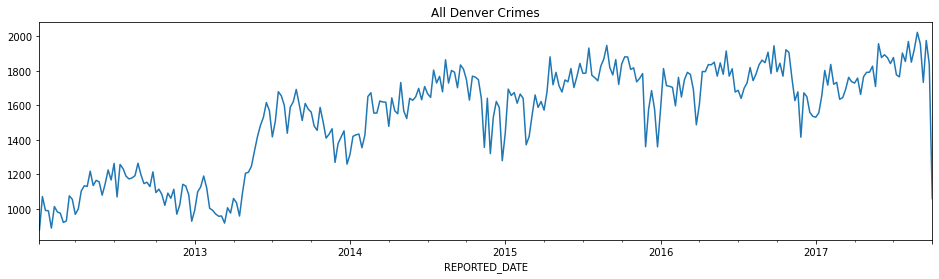

In [94]:
weekly_crimes.plot(figsize=(16,4), title='All Denver Crimes')

# Aggregating weekly crime and traffic separately

The Denver crime dataset has all crime and traffic accidents together in one table, and
separates them through the binary columns, `IS_CRIME` and `IS_TRAFFIC`. The `resample`
method allows you to group by a period of time and aggregate specific columns separately.

## Getting ready

In this recipe, we will use the `resample` method to group by each quarter of the year and
then sum up the number of crimes and traffic accidents separately.

## How to do it...

1. Read in the crime hdf5 dataset, set the index as `REPORTED_DATE`, and then sort it
to increase performance for the rest of the recipe:

In [95]:
crime_sort = pd.read_hdf('data/crime.h5', 'crime') \
               .set_index('REPORTED_DATE') \
               .sort_index()

2. Use the `resample` method to group by each quarter of the year and then sum the
`IS_CRIME` and `IS_TRAFFIC` columns for each group:

In [96]:
crime_quarterly = crime_sort.resample('Q')['IS_CRIME', 'IS_TRAFFIC'].sum()
crime_quarterly.head()

IS_CRIME  IS_TRAFFIC
REPORTED_DATE                      
2012-03-31         7882        4726
2012-06-30         9641        5255
2012-09-30        10566        5003
2012-12-31         9197        4802
2013-03-31         8730        4442

3. Notice that the dates all appear as the last day of the quarter. This is because the
offset alias, *Q*, represents the end of the quarter. Let's use the offset alias *QS* to
represent the start of the quarter:

In [97]:
crime_sort.resample('QS')['IS_CRIME', 'IS_TRAFFIC'].sum().head()

IS_CRIME  IS_TRAFFIC
REPORTED_DATE                      
2012-01-01         7882        4726
2012-04-01         9641        5255
2012-07-01        10566        5003
2012-10-01         9197        4802
2013-01-01         8730        4442

4. Let's verify these results by checking whether the second quarter of data is
correct:

In [98]:
crime_sort.loc['2012-4-1':'2012-6-30', ['IS_CRIME', 'IS_TRAFFIC']].sum()

IS_CRIME      9641
IS_TRAFFIC    5255
dtype: int64

5. It is possible to replicate this operation using the `groupby` method:

In [99]:
crime_quarterly2 = crime_sort.groupby(pd.Grouper(freq='Q'))['IS_CRIME', 'IS_TRAFFIC'].sum()
crime_quarterly2.equals(crime_quarterly)

True

6. Let's make a plot to better analyze the trends in crime and traffic accidents over
time:

<AxesSubplot:title={'center':'Denver Crimes and Traffic Accidents'}, xlabel='REPORTED_DATE'>

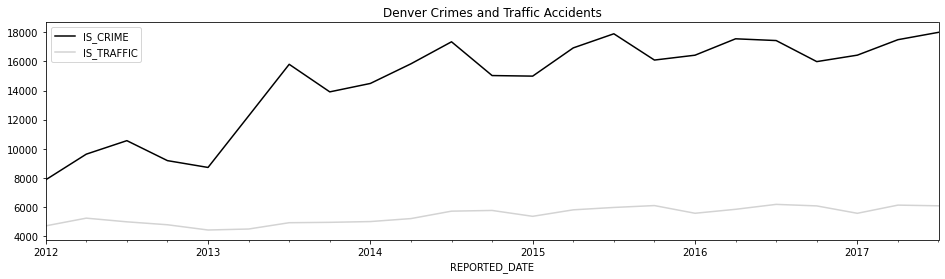

In [100]:
plot_kwargs = dict(figsize=(16,4), 
                   color=['black', 'lightgrey'], 
                   title='Denver Crimes and Traffic Accidents')
crime_quarterly.plot(**plot_kwargs)

## How it works...

After reading in and preparing our data in step 1, we begin grouping and aggregating in
step 2. Immediately after calling the `resample` method, we can continue either by chaining
a method or by selecting a group of columns to aggregate. We choose to select the
`IS_CRIME` and `IS_TRAFFIC` columns to aggregate. If we didn't select just these two, then all
of the numeric columns would have been summed with the following outcome:

In [101]:
crime_sort.resample('Q').sum().head()

GEO_LON        GEO_LAT  IS_CRIME  IS_TRAFFIC
REPORTED_DATE                                                   
2012-03-31    -1.313006e+06  496960.237747      7882        4726
2012-06-30    -1.547274e+06  585656.789182      9641        5255
2012-09-30    -1.615835e+06  611604.800384     10566        5003
2012-12-31    -1.458177e+06  551923.040048      9197        4802
2013-03-31    -1.368931e+06  518159.721947      8730        4442

By default, the offset alias *Q* technically uses December 31st as the last day of the year. The
span of dates that represent a single quarter are all calculated using this ending date. The
aggregated result uses the last day of the quarter as its label. Step 3 uses the offset alias *QS*,
which, by default, calculates quarters using January 1st as the first day of the year.

Most public businesses report quarterly earnings but they don't all have the same calendar
year beginning in January. For instance, if we wanted our quarters to begin March 1st, then
we could use *QS-MAR* to anchor our offset alias:

In [102]:
crime_sort.resample('QS-MAR')['IS_CRIME', 'IS_TRAFFIC'].sum().head()

IS_CRIME  IS_TRAFFIC
REPORTED_DATE                      
2011-12-01         5013        3198
2012-03-01         9260        4954
2012-06-01        10524        5190
2012-09-01         9450        4777
2012-12-01         9003        4652

As in the preceding recipe, we verify our results via manual slicing and replicate the result
with the `groupby` method using `pd.Grouper` to set our group length. In step 6, we make a
single call to the DataFrame `plot` method. By default, a line is plotted for each column of
data. The plot clearly shows a sharp increase in reported crimes during the first three
quarters of the year. There also appears to be a seasonal component to both crime and
traffic, with numbers lower in the cooler months and higher in the warmer months.

## There's more...

To get a different visual perspective, we can plot the percentage increase in crime and
traffic, instead of the raw count. Let's divide all the data by the first row and plot again:

In [103]:
crime_begin = crime_quarterly.iloc[0]
crime_begin

IS_CRIME      7882
IS_TRAFFIC    4726
Name: 2012-03-31 00:00:00, dtype: int64

<AxesSubplot:title={'center':'Denver Crimes and Traffic Accidents'}, xlabel='REPORTED_DATE'>

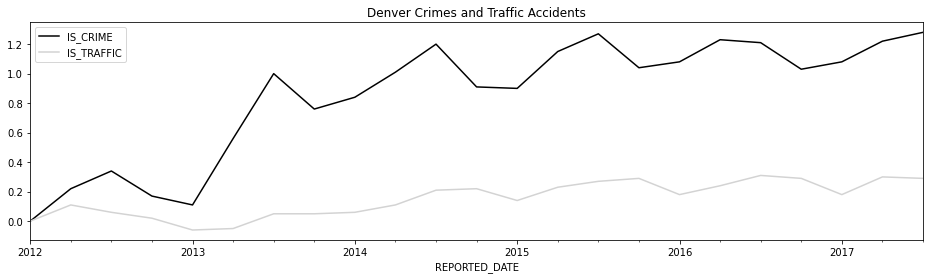

In [104]:
crime_quarterly.div(crime_begin) \
               .sub(1) \
               .round(2) \
               .plot(**plot_kwargs)

# Measuring crime by weekday and year

Measuring crimes by weekday and by year simultaneously necessitate the functionality to
pull this information directly from a Timestamp. Thankfully, this functionality is built into
any column consisting of Timestamps with the dt accessor.

## Getting ready

In this recipe, we will use the dt accessor to provide us with both the weekday name and
year of each crime as a Series. We count all of the crimes by forming groups using both of
these Series. Finally, we adjust the data to consider partial years and population before
creating a heatmap of the total amount of crime.

## How to do it...

1. Read in the Denver crime hdf5 dataset leaving the `REPORTED_DATE` as a column:

In [105]:
crime = pd.read_hdf('data/crime.h5', 'crime')
crime.head()

OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID       REPORTED_DATE  \
0   traffic-accident-dui-duid    traffic-accident 2014-06-29 02:01:00   
1  vehicular-eluding-no-chase    all-other-crimes 2014-06-29 01:54:00   
2        disturbing-the-peace     public-disorder 2014-06-29 02:00:00   
3                      curfew     public-disorder 2014-06-29 02:18:00   
4          aggravated-assault  aggravated-assault 2014-06-29 04:17:00   

      GEO_LON    GEO_LAT            NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
0 -105.000149  39.745753                        cbd         0           1  
1 -104.884660  39.738702                east-colfax         1           0  
2 -105.020719  39.706674                athmar-park         1           0  
3 -105.001552  39.769505                  sunnyside         1           0  
4 -105.018557  39.679229  college-view-south-platte         1           0

2. All Timestamp columns have a special attribute called the dt accessor, which
gives access to a variety of extra attributes and methods specifically designed for
them. Let's find the weekday name of each `REPORTED_DATE` and then count these
values:

In [106]:
wd_counts = crime['REPORTED_DATE'].dt.day_name().value_counts()
wd_counts

Monday       70024
Friday       69621
Wednesday    69538
Thursday     69287
Tuesday      68394
Saturday     58834
Sunday       55213
Name: REPORTED_DATE, dtype: int64

3. The weekends appear to have substantially less crime and traffic accidents. Let's
put this data in correct weekday order and make a horizontal bar plot:

<AxesSubplot:title={'center':'Denver Crimes and Traffic Accidents per Weekday'}>

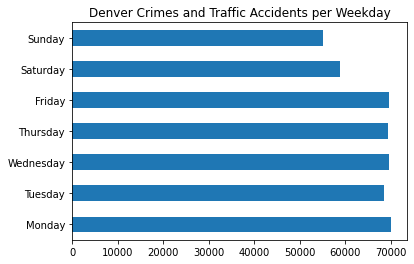

In [107]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
        'Friday', 'Saturday', 'Sunday']
title = 'Denver Crimes and Traffic Accidents per Weekday'
wd_counts.reindex(days).plot(kind='barh', title=title)

4. We can do a very similar procedure to plot the count by year:

<AxesSubplot:title={'center':'Denver Crimes and Traffic Accidents per Year'}>

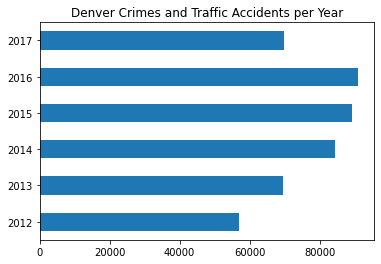

In [108]:
title = 'Denver Crimes and Traffic Accidents per Year' 
crime['REPORTED_DATE'].dt.year.value_counts() \
                              .sort_index() \
                              .plot(kind='barh', title=title)

5. We need to group by both weekday and year. One way of doing this is saving the
weekday and year Series to separate variables and then using these variables
with the `groupby` method:

In [109]:
weekday = crime['REPORTED_DATE'].dt.day_name()
year = crime['REPORTED_DATE'].dt.year
crime_wd_y = crime.groupby([year, weekday]).size()
crime_wd_y.head(10)

REPORTED_DATE  REPORTED_DATE
2012           Friday            8549
               Monday            8786
               Saturday          7442
               Sunday            7189
               Thursday          8440
               Tuesday           8191
               Wednesday         8440
2013           Friday           10380
               Monday           10627
               Saturday          8875
dtype: int64

6. We have aggregated the data correctly but the structure isn't exactly conducive to
make comparisons easily. Let's first rename those meaningless index level names
and then `unstack` the weekday level to get us a more readable table:

In [110]:
crime_table = crime_wd_y.rename_axis(['Year', 'Weekday']).unstack('Weekday')
crime_table

Weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Year                                                                   
2012       8549    8786      7442    7189      8440     8191       8440
2013      10380   10627      8875    8444     10431    10416      10354
2014      12683   12813     10950   10278     12309    12440      12948
2015      13273   13452     11586   10624     13512    13381      13320
2016      14059   13708     11467   10554     14050    13338      13900
2017      10677   10638      8514    8124     10545    10628      10576

7. We now have a nicer representation that is easier to read but noticeably, the 2017
numbers are incomplete. To help make a fairer comparison, we can make a
simple linear extrapolation to estimate the final number of crimes. Let's first find
the last day that we have data for in 2017:

In [111]:
criteria = crime['REPORTED_DATE'].dt.year == 2017
crime.loc[criteria, 'REPORTED_DATE'].dt.dayofyear.max()

272

8. A naive estimate would be to assume a constant rate of crime throughout the year
and simply multiply all values in the 2017 table by 365/272. However, we can do
a little better and look at our historical data and calculate the average percentage
of crimes that have taken place through the first 272 days of the year:

In [112]:
round(272 / 365, 3)

0.745

In [113]:
crime_pct = crime['REPORTED_DATE'].dt.dayofyear.le(272) \
                                  .groupby(year) \
                                  .mean() \
                                  .round(3)
crime_pct

REPORTED_DATE
2012    0.748
2013    0.725
2014    0.751
2015    0.748
2016    0.752
2017    1.000
Name: REPORTED_DATE, dtype: float64

In [114]:
crime_pct.loc[2012:2016].median()

0.748

9. It turns out, perhaps very coincidentally, that the percentage of crimes that
happen during the first 272 days of the year is almost exactly proportional to the
percentage of days passed in the year. Let's now update the row for 2017 and
change the column order to match the weekday order:

In [115]:
crime_table.loc[2017] = crime_table.loc[2017].div(.748).astype('int')
crime_table = crime_table.reindex(columns=days)
crime_table

Weekday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Year                                                                   
2012       8786     8191       8440      8440    8549      7442    7189
2013      10627    10416      10354     10431   10380      8875    8444
2014      12813    12440      12948     12309   12683     10950   10278
2015      13452    13381      13320     13512   13273     11586   10624
2016      13708    13338      13900     14050   14059     11467   10554
2017      14221    14208      14139     14097   14274     11382   10860

10. We could make a bar or line plot but this is also a good situation for a heatmap,
which is available with the seaborn library:

<AxesSubplot:xlabel='Weekday', ylabel='Year'>

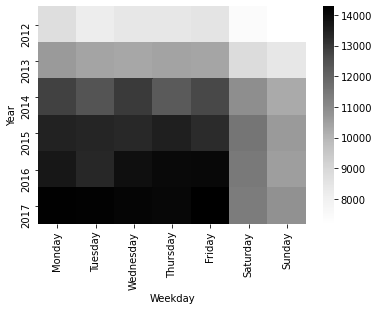

In [116]:
import seaborn as sns
sns.heatmap(crime_table, cmap='Greys')

11. Crime seems to be rising every year but this data does not account for rising
population. Let's read in a table for the Denver population for each year that we
have data:

In [117]:
denver_pop = pd.read_csv('data/denver_pop.csv', index_col='Year')
denver_pop

Population
Year            
2017      705000
2016      693000
2015      680000
2014      662000
2013      647000
2012      634000

12. Many crime metrics are reported as rates per 100,000 residents. Let's divide the
population by 100,000 and then divide the raw crime counts by this number to
get the crime rate per 100,000 residents:

In [118]:
den_100k = denver_pop.div(100000).squeeze()
crime_table2 = crime_table.div(den_100k, axis='index').astype('int')
crime_table2

Weekday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Year                                                                   
2012       1385     1291       1331      1331    1348      1173    1133
2013       1642     1609       1600      1612    1604      1371    1305
2014       1935     1879       1955      1859    1915      1654    1552
2015       1978     1967       1958      1987    1951      1703    1562
2016       1978     1924       2005      2027    2028      1654    1522
2017       2017     2015       2005      1999    2024      1614    1540

13. Once again, we can make a heatmap that, even after adjusting for population
increase, looks nearly identical to the first one:

<AxesSubplot:xlabel='Weekday', ylabel='Year'>

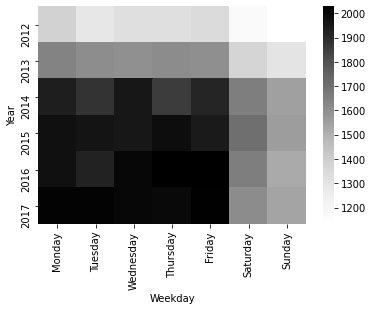

In [119]:
sns.heatmap(crime_table2, cmap='Greys')

## How it works...

All DataFrame columns containing Timestamps have access to numerous other attributes
and methods with the `dt` accessor. In fact, all of these methods and attributes available from
the `dt` accessor are also available directly from a single Timestamp object.

In step 2, we use the `dt` accessor, which only works on a Series, to extract the weekday
name and simply count the occurrences. Before making a plot in step 3, we manually
rearrange the order of the index with the `reindex` method, which, in its most basic use
case, accepts a list containing the desired order. This task could have also been
accomplished with the .loc indexer like this:

In [120]:
wd_counts.loc[days]

Monday       70024
Tuesday      68394
Wednesday    69538
Thursday     69287
Friday       69621
Saturday     58834
Sunday       55213
Name: REPORTED_DATE, dtype: int64

The `reindex` method is actually more performant and has many parameters for more
diverse situations than `.loc`. We then use the `weekday_name` attribute of the `dt` accessor to
retrieve the name of each day of the week, and count the occurrences before making a
horizontal bar plot.

In step 4, we do a very similar procedure, and retrieve the year using the `dt` accessor again,
and then count the occurrences with the `value_counts` method. In this instance, we use
`sort_index` over `reindex`, as years will naturally sort in the desired order.

The goal of the recipe is to group by both weekday and year together so this is exactly what
we do in step 5. The `groupby` method is very flexible and can form groups in multiple
ways. In this recipe, we pass it two Series, `year` and `weekday`, from which all unique
combinations form a group. We then chain the `size` method to it, which returns a single
value, the length of each group.

After step 5, our Series is long with only a single column of data, which makes it difficult to
make comparisons by year and weekday. To ease the readability, we pivot the weekday
level into horizontal column names with `unstack`.

In step 7, we use boolean indexing to select only the crimes in 2017 and then use `dayofyear`
from the `dt` accessor again to find the total elapsed days from the beginning of the year. The
maximum of this Series should tell us how many days we have data for in 2017.

Step 8 is quite complex. We first create a boolean Series by testing whether each crime was
committed on or before the 272nd day of the year with
`crime['REPORTED_DATE'].dt.dayofyear.le(272)`. From here, we again use the
flexible `groupby` method to form groups by the previously calculated `year` Series and then
use the mean method to find the percentage of crimes committed on or before the 272nd day
for each year.

The `.loc` indexer selects the entire 2017 row of data in step 9. We adjust this row by
dividing by the median percentage found in step 8.

Lots of crime visualizations are done with heatmaps and one is done here in step 10 with
the help of the `seaborn` visualization library. The cmap parameter takes a string name of
the several dozen available matplotlib colormaps (`http:/​/​bit.​ly/​2yJZOvt`).

In step 12, we create a crime rate per `100k` residents by dividing by the population of that
year. This is actually a fairly tricky operation. Normally, when you divide one DataFrame
by another, they align on their columns and index. However, in this step, `crime_table` has
no columns in common `denver_pop` so no values will align if we try and divide them. To
work around this, we create the `den_100k` Series with the `squeeze` method. We still can't
simply divide these two objects as, by default, division between a DataFrame and a Series
aligns the columns of the DataFrame with the index of the Series, like this:

In [121]:
crime_table / den_100k

2012  2013  2014  2015  2016  2017  Friday  Monday  Saturday  Sunday  \
Year                                                                         
2012   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   
2013   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   
2014   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   
2015   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   
2016   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   
2017   NaN   NaN   NaN   NaN   NaN   NaN     NaN     NaN       NaN     NaN   

      Thursday  Tuesday  Wednesday  
Year                                
2012       NaN      NaN        NaN  
2013       NaN      NaN        NaN  
2014       NaN      NaN        NaN  
2015       NaN      NaN        NaN  
2016       NaN      NaN        NaN  
2017       NaN      NaN        NaN

We need the index of the DataFrame to align with the index of Series and to do this, we use
the `div` method, which allows us to change the direction of alignment with the `axis`
parameter. A `heatmap` of the adjusted crime rate is plotted in step 13.

## There's more...

Let's finalize this analysis by writing a function to complete all the steps of this recipe at
once and add the ability to choose a specific type of crime:

In [122]:
ADJ_2017 = .748
def count_crime(df, offense_cat): 
    df = df[df['OFFENSE_CATEGORY_ID'] == offense_cat]
    weekday = df['REPORTED_DATE'].dt.day_name
    year = df['REPORTED_DATE'].dt.year
    
    ct = df.groupby([year, weekday]).size().unstack()
    ct.loc[2017] = ct.loc[2017].div(ADJ_2017).astype('int')
    
    pop = pd.read_csv('data/denver_pop.csv', index_col='Year')
    pop = pop.squeeze().div(100000)
    
    ct = ct.div(pop, axis=0).astype('int')
    ct = ct.reindex(columns=days)
    sns.heatmap(ct, cmap='Greys')
    return ct

In [123]:
# count_crime(crime, 'auto-theft')

# Grouping with anonymous functions with a DatetimeIndex

Using DataFrames with a `DatetimeIndex` opens the door to many new and different
operations as seen with several recipes in this chapter.

## Getting ready

In this recipe, we will show the versatility of using the `groupby` method for DataFrames
that have a `DatetimeIndex`.

## How to do it...

1. Read in the Denver `crime hdf5` file, place the `REPORTED_DATE` column in the
index, and sort it:

In [124]:
crime_sort = pd.read_hdf('data/crime.h5', 'crime') \
               .set_index('REPORTED_DATE') \
               .sort_index()

2. The `DatetimeIndex` itself has many of the same attributes and methods as a
pandas `Timestamp`. Let's take a look at some that they have in common:

In [125]:
common_attrs = set(dir(crime_sort.index)) & set(dir(pd.Timestamp))
print([attr for attr in common_attrs if attr[0] != '_'])

['resolution', 'day_name', 'tz', 'quarter', 'to_period', 'is_quarter_start', 'dayofyear', 'dayofweek', 'normalize', 'to_pydatetime', 'days_in_month', 'is_year_end', 'minute', 'week', 'hour', 'microsecond', 'day_of_week', 'is_leap_year', 'to_julian_date', 'is_month_end', 'year', 'month', 'strftime', 'tz_convert', 'ceil', 'day_of_year', 'to_numpy', 'max', 'tz_localize', 'floor', 'weekofyear', 'tzinfo', 'is_quarter_end', 'date', 'isocalendar', 'second', 'round', 'freqstr', 'is_month_start', 'freq', 'timetz', 'min', 'is_year_start', 'daysinmonth', 'day', 'month_name', 'time', 'weekday', 'nanosecond']


3. We can then use the index to find weekday names, similarly to what was done in
step 2 of the preceding recipe:

In [126]:
crime_sort.index.day_name().value_counts()

Monday       70024
Friday       69621
Wednesday    69538
Thursday     69287
Tuesday      68394
Saturday     58834
Sunday       55213
Name: REPORTED_DATE, dtype: int64

4. Somewhat surprisingly, the `groupby` method has the ability to accept a function
as an argument. This function will be implicitly passed the index and its return
value is used to form groups. Let's see this in action by grouping with a function
that turns the index into a weekday name and then counts the number of crimes
and traffic accidents separately:

In [127]:
crime_sort.groupby(lambda x: x.day_name())['IS_CRIME', 'IS_TRAFFIC'].sum()

IS_CRIME  IS_TRAFFIC
Friday        48833       20814
Monday        52158       17895
Saturday      43363       15516
Sunday        42315       12968
Thursday      49470       19845
Tuesday       49658       18755
Wednesday     50054       19508

5. You can use a list of functions to group by both the hour of day and year, and
then reshape the table to make it more readable:

In [128]:
funcs = [lambda x: x.round('2h').hour, lambda x: x.year]
cr_group = crime_sort.groupby(funcs)['IS_CRIME', 'IS_TRAFFIC'].sum()
cr_final = cr_group.unstack()
cr_final.style.highlight_max(color='lightgrey')

## How it works...

In step 1, we read in our data and place a column of Timestamps into the index to create a
DatetimeIndex. In step 2, we see that a DatetimeIndex has lots of the same functionality that
a single Timestamp object has. In step 3, we directly use these extra features of the
DatetimeIndex to extract the weekday name.

In step 4, we take advantage of the special ability of the `groupby` method to accept a
function that is passed the DatetimeIndex. The `x` in the anonymous function is literally the
DatetimeIndex and we use it to retrieve the weekday name. It is possible to pass `groupby` a
list of any number of custom functions, as done in step 5. Here, the first function uses the
`round` DatetimeIndex method to round each value to the nearest second hour. The second
function retrieves the year. After the grouping and aggregating, we `unstack` the years as
columns. We then highlight the maximum value of each column. Crime is reported most
often between 3 and 5 p.m. Most traffic accidents occur between 5 p.m. and 7 p.m.

## There's more...

The final result of this recipe is a DataFrame with MultiIndex columns. Using this
DataFrame, it is possible to select just the crime or traffic accidents separately. The xs
method allows you to select a single value from any index level. Let's see an example where
we select only the section of data dealing with traffic:

In [129]:
cr_final.xs('IS_TRAFFIC', axis='columns', level=0).head()

2012  2013  2014  2015  2016  2017
0   919   792   978  1136   980   782
2   718   652   779   773   718   537
4   399   378   424   471   464   313
6   411   399   479   494   593   462
8  1957  1955  2210  2331  2372  1828

This is referred to as taking a cross section in pandas. We must use the `axis` and `level`
parameters to specifically denote where our value is located. Let's use `xs` again to select
only data from 2016, which is in a different level:

In [130]:
cr_final.xs(2016, axis='columns', level=1).head()

IS_CRIME  IS_TRAFFIC
0      5377         980
2      4091         718
4      3044         464
6      2108         593
8      4488        2372

# Grouping by a Timestamp and another column

The `resample` method on its own, is unable to group by anything other than periods of
time. The `groupby` method, however, has the ability to group by both periods of time and
other columns.

## Getting ready

In this recipe, we will show two very similar but different approaches to group by
Timestamps and another column.

## How to do it...

1. Read in the `employee` dataset, and create a DatetimeIndex with the `HIRE_DATE`
column:

In [131]:
employee = pd.read_csv('data/employee.csv', 
                       parse_dates=['JOB_DATE', 'HIRE_DATE'], 
                       index_col='HIRE_DATE')
employee.head()

UNIQUE_ID               POSITION_TITLE  \
HIRE_DATE                                            
2006-06-12          0  ASSISTANT DIRECTOR (EX LVL)   
2000-07-19          1            LIBRARY ASSISTANT   
2015-02-03          2               POLICE OFFICER   
1982-02-08          3            ENGINEER/OPERATOR   
1989-06-19          4                  ELECTRICIAN   

                               DEPARTMENT  BASE_SALARY             RACE  \
HIRE_DATE                                                                 
2006-06-12    Municipal Courts Department     121862.0  Hispanic/Latino   
2000-07-19                        Library      26125.0  Hispanic/Latino   
2015-02-03  Houston Police Department-HPD      45279.0            White   
1982-02-08  Houston Fire Department (HFD)      63166.0            White   
1989-06-19    General Services Department      56347.0            White   

           EMPLOYMENT_TYPE  GENDER EMPLOYMENT_STATUS   JOB_DATE  
HIRE_DATE                                                        
2006-06-12       Full Time  Female            Active 2012-10-13  
2000-07-19       Full Time  Female            Active 2010-09-18  
2015-02-03       Full Time    Male            Active 2015-02-03  
1982-02-08       Full Time    Male            Active 1991-05-25  
1989-06-19       Full Time    Male            Active 1994-10-22

2. Let's first do a simple grouping by just gender, and find the average salary for
each:

In [132]:
employee.groupby('GENDER')['BASE_SALARY'].mean().round(-2)

GENDER
Female    52200.0
Male      57400.0
Name: BASE_SALARY, dtype: float64

3. Let's find the average salary based on hire date, and group everyone into 10-year
buckets:

In [133]:
employee.resample('10AS')['BASE_SALARY'].mean().round(-2)

HIRE_DATE
1958-01-01     81200.0
1968-01-01    106500.0
1978-01-01     69600.0
1988-01-01     62300.0
1998-01-01     58200.0
2008-01-01     47200.0
Freq: 10AS-JAN, Name: BASE_SALARY, dtype: float64

4. If we wanted to group by both gender and a five-year time span, we can call
`resample` directly after calling `groupby`:

In [134]:
sal_avg = employee.groupby('GENDER').resample('10AS')['BASE_SALARY'].mean().round(-2)
sal_avg

GENDER  HIRE_DATE 
Female  1975-01-01     51600.0
        1985-01-01     57600.0
        1995-01-01     55500.0
        2005-01-01     51700.0
        2015-01-01     38600.0
Male    1958-01-01     81200.0
        1968-01-01    106500.0
        1978-01-01     72300.0
        1988-01-01     64600.0
        1998-01-01     59700.0
        2008-01-01     47200.0
Name: BASE_SALARY, dtype: float64

5. Now, this does what we set out to do, but we run into a slight issue whenever we
want to compare female to male salaries. Let's `unstack` the gender level and see
what happens:

In [135]:
sal_avg.unstack('GENDER')

GENDER       Female      Male
HIRE_DATE                    
1958-01-01      NaN   81200.0
1968-01-01      NaN  106500.0
1975-01-01  51600.0       NaN
1978-01-01      NaN   72300.0
1985-01-01  57600.0       NaN
1988-01-01      NaN   64600.0
1995-01-01  55500.0       NaN
1998-01-01      NaN   59700.0
2005-01-01  51700.0       NaN
2008-01-01      NaN   47200.0
2015-01-01  38600.0       NaN

6. The 10-year periods for males and females do not begin on the same date. This
happened because the data was first grouped by gender and then, within each
gender, more groups were formed based on hire dates. Let's verify that the first
hired male was in 1958 and the first hired female was in 1975:

In [136]:
employee[employee['GENDER'] == 'Male'].index.min()

Timestamp('1958-12-29 00:00:00')

In [137]:
employee[employee['GENDER'] == 'Female'].index.min()

Timestamp('1975-06-09 00:00:00')

7. To resolve this issue, we must group the date together with the gender, and this
is only possible with the `groupby` method:

In [138]:
sal_avg2 = employee.groupby(['GENDER', pd.Grouper(freq='10AS')])['BASE_SALARY'].mean().round(-2)
sal_avg2

GENDER  HIRE_DATE 
Female  1968-01-01         NaN
        1978-01-01     57100.0
        1988-01-01     57100.0
        1998-01-01     54700.0
        2008-01-01     47300.0
Male    1958-01-01     81200.0
        1968-01-01    106500.0
        1978-01-01     72300.0
        1988-01-01     64600.0
        1998-01-01     59700.0
        2008-01-01     47200.0
Name: BASE_SALARY, dtype: float64

8. Now we can `unstack` the gender and get our rows aligned perfectly:

In [139]:
sal_final = sal_avg2.unstack('GENDER')
sal_final

GENDER       Female      Male
HIRE_DATE                    
1958-01-01      NaN   81200.0
1968-01-01      NaN  106500.0
1978-01-01  57100.0   72300.0
1988-01-01  57100.0   64600.0
1998-01-01  54700.0   59700.0
2008-01-01  47300.0   47200.0

## How it works...

The `read_csv` function in step 1 allows to both convert columns into Timestamps and put
them in the index at the same time creating a DatetimeIndex. Steps 2 does a simple
`groupby` operation with a single grouping column, gender. Step 3 uses the `resample`
method with the offset alias *10AS* to form groups in 10-year increments of time. The A is the
alias for year and the S informs us that the beginning of the period is used as the label. For
instance, the data for the label *1988-01-01* spans that date until December 31, 1997.

Interestingly, the object returned from a call to the `groupby` method has its own `resample`
method, but the reverse is not true:

In [140]:
'resample' in dir(employee.groupby('GENDER'))

True

In [141]:
'groupby' in dir(employee.resample('10AS'))

True

In step 4, for each gender, male and female, completely different starting dates for the 10-
year periods are calculated based on the earliest hired employee. Step 6 verifies that the
year of the earliest hired employee for each gender matches the output from step 4. Step 5
shows how this causes misalignment when we try to compare salaries of females to males.
They don't have the same 10-year periods.

To alleviate this issue, we must group both the gender and Timestamp together. The
`resample` method is only capable of grouping by a single column of Timestamps. We can
only complete this operation with the `groupby` method. With `pd.Grouper`, we can
replicate the functionality of `resample`. We simply pass the offset alias to the `freq`
parameter and then place the object in a list with all the other columns that we wish to
group, as done in step 7. As both males and females now have the same starting dates for
the 10-year period, the reshaped data in step 8 will align for each gender making
comparisons much easier. It appears that male salaries tend to be higher given a longer
length of employment, though both genders have the same average salary with under 10
years of employment.

## There's more...

From an outsider's perspective, it would not be obvious that the rows from the output in
step 8 represented 10-year intervals. One way to improve the index labels would be to show
the beginning and end of each time interval. We can achieve this by concatenating the
current index year with 9 added to itself:

In [142]:
years = sal_final.index.year
years_right = years + 9
sal_final.index = years.astype(str) + '-' + years_right.astype(str)
sal_final

GENDER      Female      Male
HIRE_DATE                   
1958-1967      NaN   81200.0
1968-1977      NaN  106500.0
1978-1987  57100.0   72300.0
1988-1997  57100.0   64600.0
1998-2007  54700.0   59700.0
2008-2017  47300.0   47200.0

There is actually a completely different way to do this recipe. We can use the `cut` function
to create equal-width intervals based on the year that each employee was hired and form
groups from it:

In [143]:
cuts = pd.cut(employee.index.year, bins=5, precision=0)
cuts.categories.values

<IntervalArray>
[(1958.0, 1970.0], (1970.0, 1981.0], (1981.0, 1993.0], (1993.0, 2004.0], (2004.0, 2016.0]]
Length: 5, closed: right, dtype: interval[float64]

In [144]:
employee.groupby([cuts, 'GENDER'])['BASE_SALARY'].mean().unstack('GENDER').round(-2)

GENDER             Female     Male
(1958.0, 1970.0]      NaN  85400.0
(1970.0, 1981.0]  54400.0  72700.0
(1981.0, 1993.0]  55700.0  69300.0
(1993.0, 2004.0]  56500.0  62300.0
(2004.0, 2016.0]  49100.0  49800.0

# Finding the last time crime was 20% lower with merge_asof

There are frequently times where we would like to know when the last time something
happened. For example, we might be interested in the last time unemployment was below
5% or the last time the stock market went up five days in a row or the last time you had
eight hours of sleep. The `merge_asof` function provides answers to these types of
questions.

## Getting ready

In this recipe, we will find the current month's total number of crimes for each offense
category and then find the last time there were 20% fewer incidences.

## How to do it...

1. Read in the Denver crime dataset, place the `REPORTED_DATE` in the index, and
sort it:

In [145]:
crime_sort = pd.read_hdf('data/crime.h5', 'crime') \
               .set_index('REPORTED_DATE') \
               .sort_index()

2. Find the last full month of data:

In [146]:
crime_sort.index.max()

Timestamp('2017-09-29 06:16:00')

3. As we don't quite have all of September's data, let's drop it from our dataset:

In [147]:
crime_sort = crime_sort[:'2017-8']
crime_sort.index.max()

Timestamp('2017-08-31 23:52:00')

4. Let's count the number of crimes and traffic accidents for every month:

In [148]:
all_data = crime_sort.groupby([pd.Grouper(freq='M'), 'OFFENSE_CATEGORY_ID']).size()
all_data.head()

REPORTED_DATE  OFFENSE_CATEGORY_ID
2012-01-31     aggravated-assault     113
               all-other-crimes       124
               arson                    5
               auto-theft             275
               burglary               343
dtype: int64

5. Although the `merge_asof` function can work with the index, it will be easier to
just reset it:

In [149]:
all_data = all_data.sort_values().reset_index(name='Total')
all_data.head()

REPORTED_DATE OFFENSE_CATEGORY_ID  Total
0    2012-01-31              murder      0
1    2016-05-31              murder      1
2    2013-01-31               arson      1
3    2016-12-31              murder      1
4    2014-12-31              murder      1

6. Let's get the current month's crime count and make a new column to represent
the goal:

In [150]:
goal = all_data[all_data['REPORTED_DATE'] == '2017-8-31'].reset_index(drop=True)
goal['Total_Goal'] = goal['Total'].mul(.8).astype(int)
goal.head()

REPORTED_DATE OFFENSE_CATEGORY_ID  Total  Total_Goal
0    2017-08-31              murder      7           5
1    2017-08-31               arson      7           5
2    2017-08-31      sexual-assault     57          45
3    2017-08-31             robbery    108          86
4    2017-08-31  white-collar-crime    138         110

7. Now use the `merge_asof` function to find the last time a monthly crime total was
less than the column `Total_Goal` for each offense category:

In [151]:
pd.merge_asof(goal, all_data, left_on='Total_Goal', right_on='Total', 
              by='OFFENSE_CATEGORY_ID', suffixes=('_Current', '_Last'))

REPORTED_DATE_Current           OFFENSE_CATEGORY_ID  Total_Current  \
0             2017-08-31                        murder              7   
1             2017-08-31                         arson              7   
2             2017-08-31                sexual-assault             57   
3             2017-08-31                       robbery            108   
4             2017-08-31            white-collar-crime            138   
5             2017-08-31            aggravated-assault            195   
6             2017-08-31  other-crimes-against-persons            376   
7             2017-08-31                      burglary            432   
8             2017-08-31                    auto-theft            599   
9             2017-08-31                  drug-alcohol            636   
10            2017-08-31      theft-from-motor-vehicle            675   
11            2017-08-31                       larceny            877   
12            2017-08-31               public-disorder            878   
13            2017-08-31              all-other-crimes           1583   
14            2017-08-31              traffic-accident           2126   

    Total_Goal REPORTED_DATE_Last  Total_Last  
0            5         2017-05-31           5  
1            5         2012-01-31           5  
2           45         2013-01-31          45  
3           86         2015-03-31          86  
4          110         2016-10-31         110  
5          156         2016-05-31         154  
6          300         2014-04-30         285  
7          345         2012-01-31         343  
8          479         2017-07-31         477  
9          508         2015-05-31         505  
10         540         2015-03-31         535  
11         701         2015-01-31         697  
12         702         2015-12-31         699  
13        1266         2016-11-30        1264  
14        1700         2013-12-31        1697

## How it works...

After reading in our data, we decide not to include the 2017 September data, as it is not
quite a complete month. We use a partial date string to slice all the way up to and including
any crimes in August of 2017. In step 4, we tally all the crimes for each offense category per
month, and in step 5, we sort by this total, which is required for `merge_asof`.

In step 6, we select the most recent data into a separate DataFrame. We will use this month
of August as our baseline and create a column, `Total_Goal`, that is 20% less than the
current. In step 7, we use `merge_asof` to find the last time a monthly crime count was less
than the `Total_Goal` column.

## There's more...

In addition to the Timestamp and Timedelta data types, pandas offers the Period type to
represent an exact time period. For example, *2012-05* would represent the entire month of
May, 2012. You can manually construct a Period in the following manner:

In [152]:
pd.Period(year=2012, month=5, day=17, hour=14, minute=20, freq='T')

Period('2012-05-17 14:20', 'T')

This object represents the entire minute of May 17, 2012 at 2:20 p.m. It is possible to use
these Periods in step 4 instead of grouping by date with `pd.Grouper`. DataFrames with a
DatetimeIndex have the `to_period` method to convert Timestamps to Periods. It accepts an
offset alias to determine the exact length of the time period.

In [153]:
crime_sort.index.to_period('M')

PeriodIndex(['2012-01', '2012-01', '2012-01', '2012-01', '2012-01', '2012-01',
             '2012-01', '2012-01', '2012-01', '2012-01',
             ...
             '2017-08', '2017-08', '2017-08', '2017-08', '2017-08', '2017-08',
             '2017-08', '2017-08', '2017-08', '2017-08'],
            dtype='period[M]', name='REPORTED_DATE', length=453568, freq='M')

In [154]:
ad_period = crime_sort.groupby([lambda x: x.to_period('M'), 
                                'OFFENSE_CATEGORY_ID']).size()
ad_period = ad_period.sort_values() \
                     .reset_index(name='Total') \
                     .rename(columns={'level_0':'REPORTED_DATE'})
ad_period.head()

REPORTED_DATE OFFENSE_CATEGORY_ID  Total
0       2012-01              murder      0
1       2016-05              murder      1
2       2013-01               arson      1
3       2016-12              murder      1
4       2014-12              murder      1

Let's verify that the last two columns from this DataFrame are equivalent to `all_data` from
step 5:

In [155]:
cols = ['OFFENSE_CATEGORY_ID', 'Total']
all_data[cols].equals(ad_period[cols])

True

Steps 6 and 7 can now be replicated in almost the exact same manner with the following
code:

In [156]:
aug_2018 = pd.Period('2017-8', freq='M')
goal_period = ad_period[ad_period['REPORTED_DATE'] == aug_2018].reset_index(drop=True)
goal_period['Total_Goal'] = goal_period['Total'].mul(.8).astype(int)
pd.merge_asof(goal_period, ad_period, left_on='Total_Goal', right_on='Total', 
                  by='OFFENSE_CATEGORY_ID', suffixes=('_Current', '_Last')).head()


REPORTED_DATE_Current OFFENSE_CATEGORY_ID  Total_Current  Total_Goal  \
0               2017-08              murder              7           5   
1               2017-08               arson              7           5   
2               2017-08      sexual-assault             57          45   
3               2017-08             robbery            108          86   
4               2017-08  white-collar-crime            138         110   

  REPORTED_DATE_Last  Total_Last  
0            2017-05           5  
1            2012-01           5  
2            2013-01          45  
3            2015-03          86  
4            2016-10         110